<a href="https://colab.research.google.com/gist/ashwinkey04/de066da294792f198b7f74ad6ec702e8/fyp_phase_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 1

> Gathering news articles and stock prices for a specific stock and preparing the dataset for sentiment analysis and stock value prediction


#### How it works
> This notebook fetches daily stock market data of a specified stock from [yfinance](https://www.yahoofinanceapi.com/) api and its daily news articles from [mediastack](https://mediastack.com/) api and creates a derived dataset which contains **news sentiment**. This notebook can be scheduled to run daily on Google Cloud Run to gather data daily




#### stock_history.csv 

1. Date - Trading date
2. Open - Open price of day
3. High - Highest price of day
4. Low - Lowest price of day
5. Close - Closing price of day
6. Volume - Amount of asset/security 
7. Dividends - Distribution of stock
8. Stock splits - Shares of stock to its current shareholders


#### news.json

1. author - author of news article 
2. title - title of news article 
3. description - description of news article
4. url - url of news article
5. source - source of news article
6. image - image of news article
7. category - category of news article
8. language - language of news article
9. country - country name
10. published_at - published date

#### news_sentiment.csv

1. published_at - published date
2. title - title of news article 
3. description - description of news article
4. url - url of news article
5. sentiment - news sentiment
6. sentiment_score - news sentiment score between 0 to 1



## Installing packages


In [1]:
# Install Yahoo Finance package
%pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 KB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [70]:
# Install Google cloud helper package
%pip install firebase-admin

  Using cached firebase_admin-6.0.1-py3-none-any.whl (119 kB)
  Using cached google_api_python_client-2.74.0-py2.py3-none-any.whl (10.9 MB)
  Using cached CacheControl-0.12.11-py2.py3-none-any.whl (21 kB)
  Using cached google_cloud_storage-2.7.0-py2.py3-none-any.whl (110 kB)
  Using cached google_api_core-2.11.0-py3-none-any.whl (120 kB)
  Using cached google_cloud_firestore-2.9.1-py2.py3-none-any.whl (265 kB)
  Using cached protobuf-4.21.12-cp37-abi3-macosx_10_9_universal2.whl (486 kB)
  Using cached google_auth-2.16.0-py2.py3-none-any.whl (177 kB)
  Using cached googleapis_common_protos-1.58.0-py2.py3-none-any.whl (223 kB)
  Using cached grpcio_status-1.51.1-py3-none-any.whl (5.1 kB)
  Using cached google_auth_httplib2-0.1.0-py2.py3-none-any.whl (9.3 kB)
  Using cached google_cloud_core-2.3.2-py2.py3-none-any.whl (29 kB)
  Using cached google_resumable_media-2.4.1-py2.py3-none-any.whl (77 kB)
  Using cached google_crc32c-1.5.0-cp38-cp38-macosx_10_9_universal2.whl (32 kB)
  Attemptin

In [2]:
# Install Transformers package for transfer learning
%pip install transformers

#Install pmdarima package for ARIMA
%pip install pmdarima

Note: you may need to restart the kernel to use updated packages.
  Using cached pmdarima-2.0.2-cp38-cp38-macosx_11_0_arm64.whl (573 kB)
Note: you may need to restart the kernel to use updated packages.


## Importing packages

In [ ]:
# Optional: To fix descriptors not found error in transformers package
# %pip install grpcio-status==1.33.2 protobuf==3.19.6

In [1]:
# Import other libraries 
import yfinance as yf
import pandas as pd
import numpy as np
import os
import json
import datetime
from datetime import date,timedelta
import warnings
import http.client, urllib.parse

warnings.filterwarnings("ignore")
from transformers import AutoTokenizer, AutoModelForSequenceClassification,pipeline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

## Define parameters

In [2]:
# company symbol and name
company_symbol="ICICIBANK.BO"
company_name="ICICI"

In [22]:

#Initialise today date
today = str(date.today())
yesterday = str(date.today()- timedelta(days = 1))
start_date = "2018-01-31"

# flag variables
news_inserted=False

#secret key of mediastack api
mediastack_api_token = "9f774391108184659c6eecd8dfdcd269"

# input file paths
stock_history_file_path='./input/{}_stock_history.csv'.format(company_name)
news_file_path='./input/{}_news.json'.format(company_name)
news_sentiment_file_path='./input/{}_news_sentiment.csv'.format(company_name)

# output file paths
output_stock_history_file_path='./{}_stock_history.csv'.format(company_name)
output_news_file_path='./{}_news.json'.format(company_name)
output_news_sentiment_file_path='./{}_news_sentiment.csv'.format(company_name)

# parameters for mediastack api
search_query=company_name
conn = http.client.HTTPConnection('api.mediastack.com')
def get_news_params(offset):
    return urllib.parse.urlencode({
    'keywords': search_query,
    'access_key': mediastack_api_token,
    'sort': 'published_desc',
    'offset': offset,
    'limit': 100,
    'languages': 'en',
    })

In [23]:
start_date+today

'2018-01-312023-02-06'

## Create dataset

In [208]:
ticker_object=yf.Ticker(company_symbol)

In [18]:
def create_stock_history_dataset():
    fin_stock_history=ticker_object.history(start=start_date, end=today).reset_index()
    return fin_stock_history

def update_stock_history_dataset():
    fin_stock_history=pd.read_csv(stock_history_file_path)
    fin_stock_history.Date=pd.to_datetime(fin_stock_history.Date, format='%Y/%m/%d')
    today_fin_stock_data=ticker_object.history(period="3d")
    today_fin_stock_data=today_fin_stock_data.reset_index()
    last_stock_date=str(today_fin_stock_data.loc[0,'Date']).split()[0]
    if last_stock_date == fin_stock_history['Date'].dt.strftime('%Y-%m-%d')[len(fin_stock_history)-1]: #if already inserted 
        fin_stock_history.iloc[-1:,:]=today_fin_stock_data.iloc[-1].tolist()
    else:
        last_position=len(fin_stock_history)
        fin_stock_history.loc[last_position]=today_fin_stock_data.iloc[-1].tolist()
    return fin_stock_history

In [19]:
# create stock market history dataset
ticker_object=yf.Ticker(company_symbol)
if os.path.exists(stock_history_file_path)==False:
    fin_stock_history=create_stock_history_dataset()
    print('Created new stock history dataset')
else:
    fin_stock_history=update_stock_history_dataset()
    print('Updated existing stock history dataset')

fin_stock_history.to_csv(output_stock_history_file_path,index=False)

Created new stock history dataset


## Create/Update news dataset

In [15]:
def create_news_dataset():
    global res
    print('Creating news dataset')
    conn.request('GET', '/v1/news?{}'.format(get_news_params(0)))
    res = conn.getresponse().read()
    print(res)
    fin_news=json.loads(res.decode('utf-8'))["data"]
    return fin_news

def update_news_dataset():
    print('Updating news dataset')
    global news_inserted
    with open(news_file_path,'r') as file:
        fin_news=json.load(file)
        for news in fin_news['articles']:
            if news['published_at'].split('T')[0]==yesterday:
                news_inserted=True
                break
        current_fin_news=None
        if news_inserted==False:
            conn.request('GET', '/v1/news?{}'.format(params))
            res = conn.getresponse().read()
            current_fin_news=json.loads(res.decode('utf-8'))["data"]
            fin_news['articles']+=current_fin_news
        return fin_news['articles'],current_fin_news

In [ ]:
#create news dataset 
if os.path.exists(news_file_path)==False:
    fin_news=create_news_dataset()
    current_fin_news=fin_news.copy()
else:
    fin_news,current_fin_news=update_news_dataset()

with open(output_news_file_path,'w') as file:
    json.dump({"articles":fin_news},file)

## Predict sentiment on articles


In [215]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

In [217]:
def create_news_sentiment_dataset(news_sentiments):
    last_position=len(news_sentiments)
    article_ind=last_position
    title_description=[]
    if current_fin_news!=None:
        print('News not empty')
        for article in current_fin_news:
            title_description.append(article['title']+' '+article['description'])
            news_sentiments.at[article_ind,'published_at']=article['published_at']
            news_sentiments.at[article_ind,'title']=article['title']
            news_sentiments.at[article_ind,'description']=article['description']
            news_sentiments.at[article_ind,'url']=article['url']
            article_ind+=1
        news_label_and_scores=classifier(list(title_description))
        labels=[pred['label'] for pred in news_label_and_scores]    
        scores=[pred['score'] for pred in news_label_and_scores]
        news_sentiments.at[last_position:,'sentiment']=labels
        news_sentiments.at[last_position:,'sentiment_score']=scores
    else:
        print('News IS empty')
    news_sentiments.to_csv(output_news_sentiment_file_path,index=None)  

## Add news sentiment

In [218]:
news_sentiments=None
if os.path.exists(news_sentiment_file_path):
    news_sentiments=pd.read_csv(news_sentiment_file_path,index_col=None)                     
else:
    news_sentiments=pd.DataFrame(columns=['published_at','title','description','url','sentiment','sentiment_score'])
create_news_sentiment_dataset(news_sentiments)

News not empty


### Connect to Google Cloud backend

In [37]:
#Authenticate with Google Cloud using a service account private key
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

cred = credentials.Certificate("./pred-fyp-d6faf9e4428c.json")
# if not firebase_admin._apps:
firebase_admin.initialize_app(credential = cred, name = "PRED")

In [ ]:
#Connect to the database
db = firestore.client()
sentiment_coll = db.collection('news_sentiments')
reliance_doc_ref = sentiment_coll.document(u'RELIANCE')

In [ ]:
news_sentiments['published'] = news_sentiments['published_at']
news_sentiments.set_index('published_at').to_dict()

In [ ]:
#Update DB with predicted sentiments
reliance_doc_ref.set(news_sentiments.set_index('published_at').to_dict())

# Phase 2


## ARIMA Model for Time series forcasting

### Importing packages and preparing dataframe

In [223]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [26]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv(output_stock_history_file_path,sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
stock_data.head(20)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-01-31,339.288255,343.609482,333.607550,342.735535,1743678,0.0,0
2018-02-01,339.579563,345.405921,333.704635,335.743866,1990660,0.0,0
2018-02-02,330.160239,333.850254,323.848352,325.110718,1251325,0.0,0
2018-02-05,320.352526,330.645762,316.565400,322.051880,2172595,0.0,0
2018-02-06,309.622375,327.926855,302.582192,321.177979,914562,0.0,0
2018-02-07,325.304966,326.567332,320.449668,322.634552,626899,0.0,0
2018-02-08,322.634556,328.460913,320.352560,324.867981,677037,0.0,0
2018-02-09,314.623348,318.993117,313.603747,317.293762,584968,0.0,0
2018-02-12,324.236826,324.236826,314.040699,316.565460,470902,0.0,0


### Stationarize data
Before using the ARIMA model, we have to ensure that our data is stationarized. For a data to be stationarized:

1. The mean of the series should not be a function of time.
2. The variance of the series should not be a function of time.
3. the covariance of the i th term and the (i + m) th term should not be a function of time.


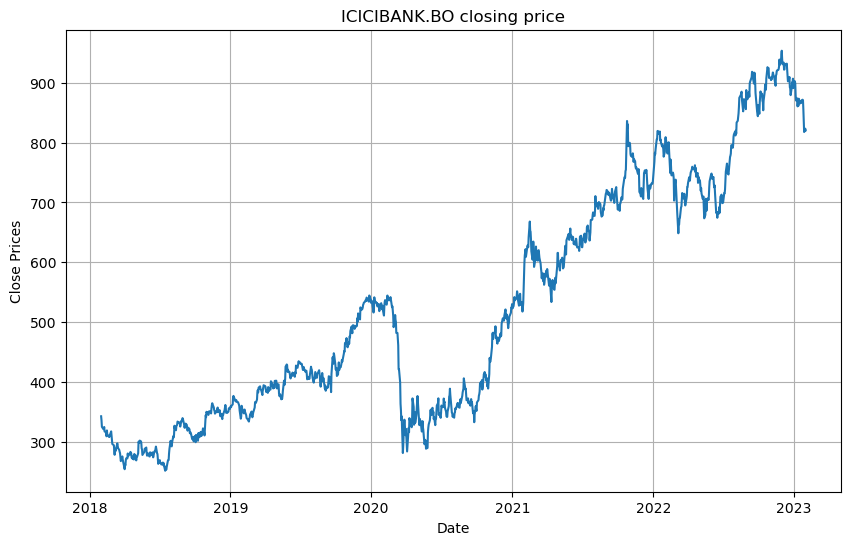

In [225]:
#Plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('{} closing price'.format(company_symbol))
plt.show()

<AxesSubplot:ylabel='Density'>

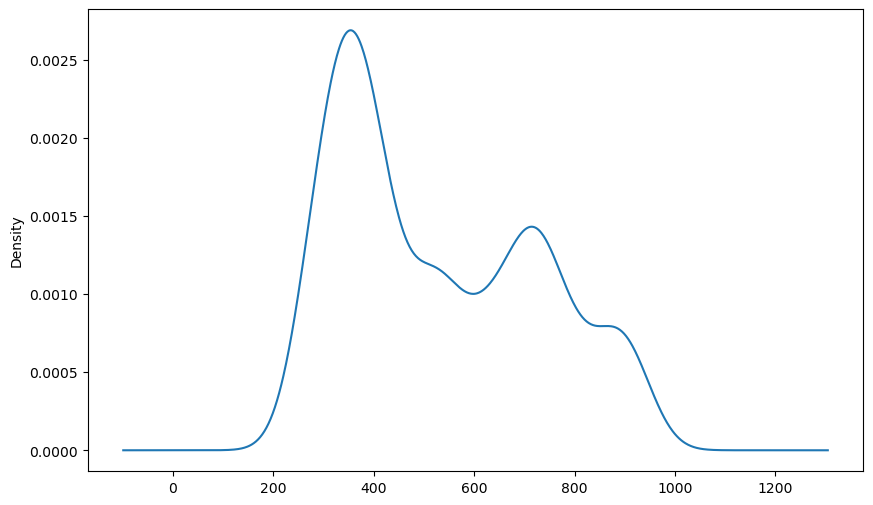

In [226]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

#### ADF (Augmented Dickey-Fuller) Test
ADF is used to determine whether the series has a unit root or not, therefore determining if series is stationary or not


- **Null Hypothesis**: The series has a unit root (value of a =1)
- **Alternate Hypothesis**: The series has no unit root.

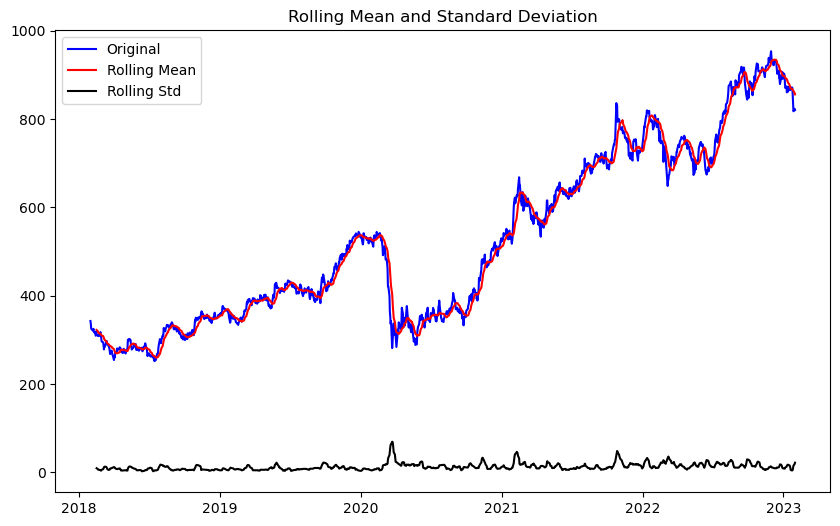

Results of dickey fuller test
Test Statistics                  -0.745288
p-value                           0.834668
No. of lags used                  5.000000
Number of observations used    1230.000000
critical value (1%)              -3.435678
critical value (5%)              -2.863893
critical value (10%)             -2.568023
dtype: float64



In [227]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output,end ='\n\n')
test_stationarity(df_close)

No handles with labels found to put in legend.


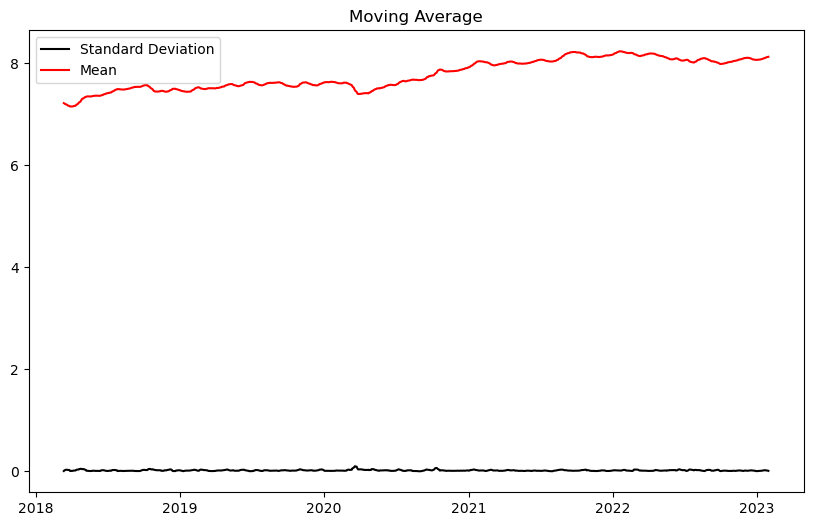

In [177]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

### Train model with best parameters

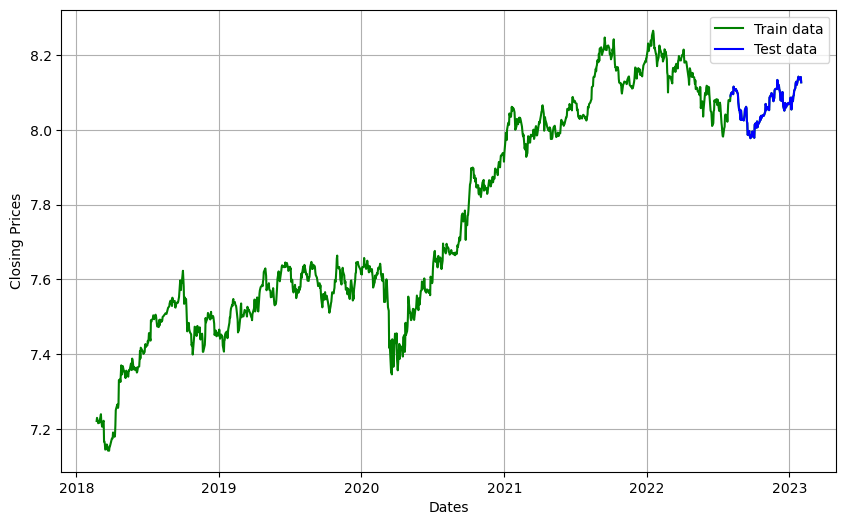

In [229]:
# Split data into train and test
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.48 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-3218.301, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-5339.049, Time=1.38 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-4180.267, Time=1.33 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-3189.392, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-5114.854, Time=0.14 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-5471.673, Time=11.84 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=10.55 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.50 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-3244.977, Time=5.13 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-5469.877, Time=10.49 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=-5469.900, Time=8.37 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=-4197.536, Time=7.31 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=-5467.808, Time=11.21 sec
 ARIMA(1,0,0)(2,1,0

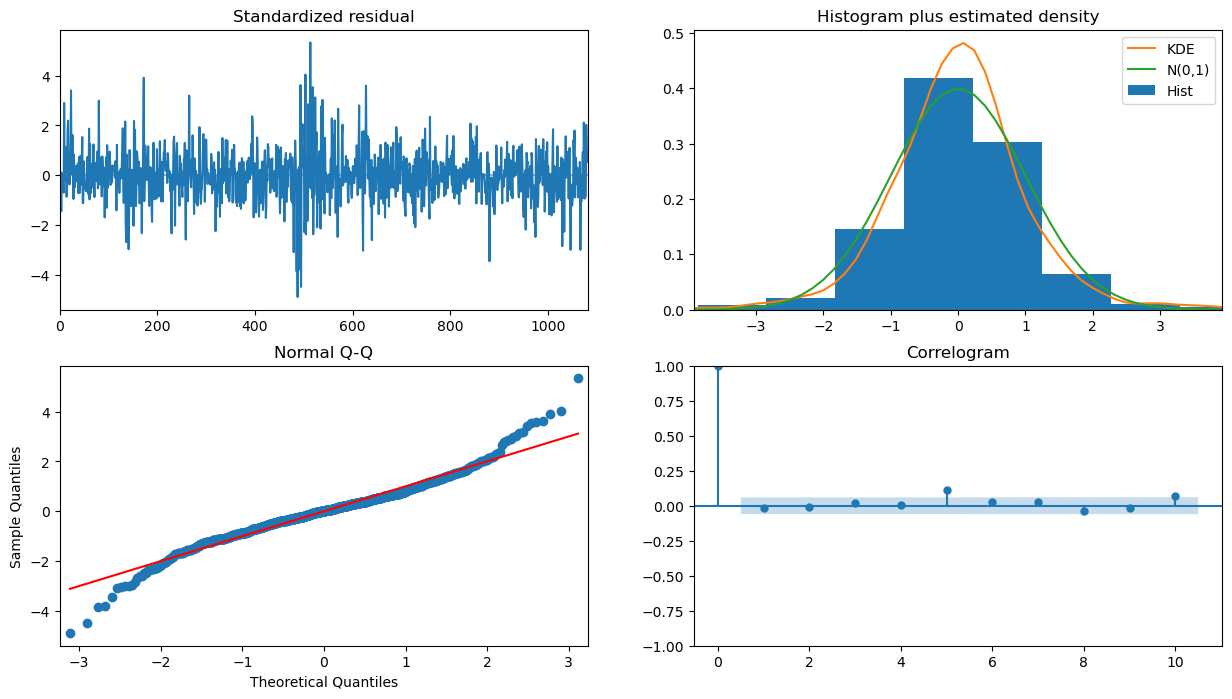

In [230]:
# Use auto_arima to find the best AR,I, and MA parameters for our model
stepwise_fit = auto_arima(train_data, start_p = 1, start_q = 1,
                            max_p = 3, max_q = 3, m = 12,
                            start_P = 0, seasonal = True,
                            d = None, D = 1, trace = True,
                            error_action ='ignore',
                            suppress_warnings = True,
                            stepwise = True)

print(stepwise_fit.summary())
stepwise_fit.plot_diagnostics(figsize=(15,8))
plt.show()

In [231]:
# Build Model
model = ARIMA(train_data, order=(1,0,1))  
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1095
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2920.835
Date:                Tue, 31 Jan 2023   AIC                          -5833.671
Time:                        12:03:34   BIC                          -5813.677
Sample:                             0   HQIC                         -5826.105
                               - 1095                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7501      0.147     52.582      0.000       7.461       8.039
ar.L1          0.9975      0.002    637.793      0.000       0.994       1.001
ma.L1         -0.0385      0.023     -1.698      0.0

In [232]:
train_data, test_data = df_close[0:int(len(df_close)*0.7)], df_close[int(len(df_close)*0.7):]
training_data = train_data.values
test_data = test_data.values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(3,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)

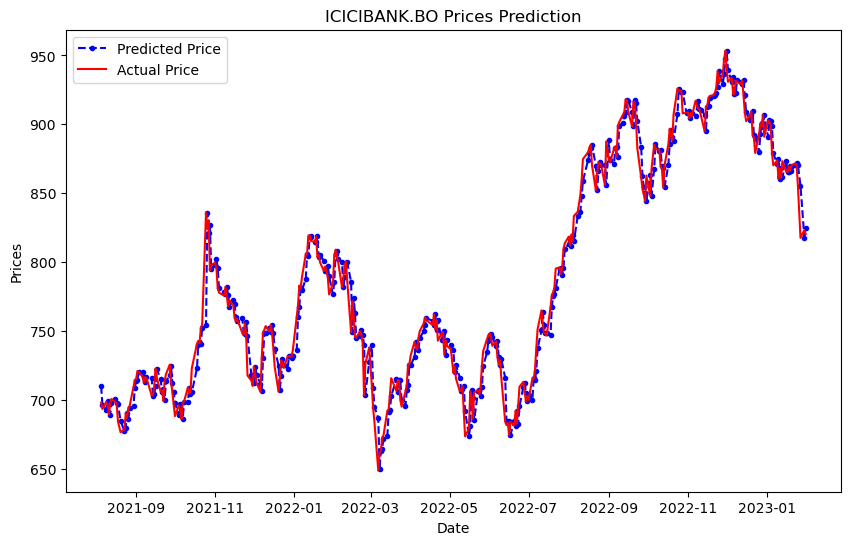

In [233]:
test_set_range = df_close[int(len(df_close)*0.7):].index
plt.plot(test_set_range, model_predictions, color='blue', marker='.', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('{} Prices Prediction'.format(company_symbol))
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

In [234]:
model = ARIMA(df_close, order=(3,1,0))
model_fit = model.fit()
output = model_fit.forecast()

print('Predicted closing price for today: {}'.format(output[output.keys().start]))

Predicted closing price for today: 821.7182442816485


#### Model Evaluation

In [235]:
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))
mape = np.mean(np.abs(model_predictions - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

Testing Mean Squared Error is 136.73108944876688
MAPE: 0.01100089160620687


## Vanilla LSTM  

In [44]:
### Importing packages
import itertools
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [27]:
stock_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-01-31,339.288255,343.609482,333.607550,342.735535,1743678,0.0,0
2018-02-01,339.579563,345.405921,333.704635,335.743866,1990660,0.0,0
2018-02-02,330.160239,333.850254,323.848352,325.110718,1251325,0.0,0
2018-02-05,320.352526,330.645762,316.565400,322.051880,2172595,0.0,0
2018-02-06,309.622375,327.926855,302.582192,321.177979,914562,0.0,0
...,...,...,...,...,...,...,...
2023-01-30,801.549988,826.000000,796.099976,823.200012,806638,0.0,0
2023-01-31,825.000000,838.250000,814.700012,831.650024,246535,0.0,0
2023-02-01,842.900024,875.250000,823.549988,846.650024,8271907,0.0,0


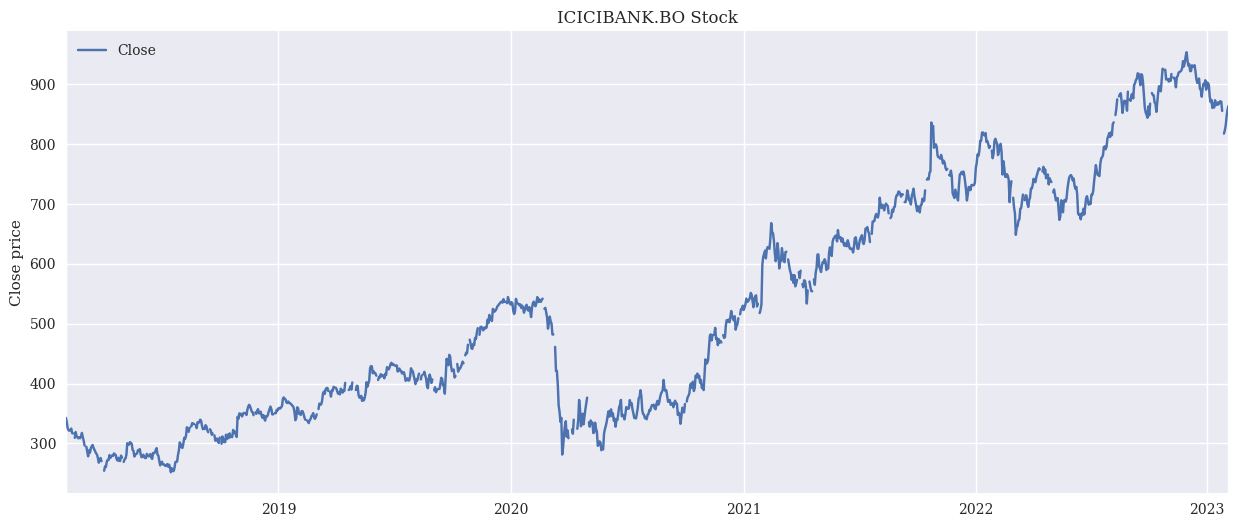

In [32]:
dates = pd.date_range(start_date,'2023-02-03',freq='B')
df1=pd.DataFrame(index=dates)
df_fin=pd.read_csv(output_stock_history_file_path, parse_dates=True, index_col=0)
df_fin=df1.join(df_fin)
df_fin[['Close']].plot(figsize=(15, 6))
plt.ylabel("Close price")
plt.title("{} Stock".format(company_symbol))
plt.show()

In [33]:
df_fin=df_fin[['Close']]
df_fin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1308 entries, 2018-01-31 to 2023-02-03
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1237 non-null   float64
dtypes: float64(1)
memory usage: 52.7 KB


In [34]:
df_fin=df_fin.fillna(method='ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))
df_fin['Close'] = scaler.fit_transform(df_fin['Close'].values.reshape(-1,1))

In [36]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_fin, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (998, 59, 1)
y_train.shape =  (998, 1)
x_test.shape =  (250, 59, 1)
y_test.shape =  (250, 1)


In [37]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [38]:
y_train.size(),x_train.size()

(torch.Size([998, 1]), torch.Size([998, 59, 1]))

In [39]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [40]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Should skip if LSTM is to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.03987464681267738
Epoch  20 MSE:  0.012817111797630787
Epoch  30 MSE:  0.004826504271477461
Epoch  40 MSE:  0.0030822299886494875
Epoch  50 MSE:  0.0022249335888773203
Epoch  60 MSE:  0.001963474554941058
Epoch  70 MSE:  0.0018161081243306398
Epoch  80 MSE:  0.0017077157972380519
Epoch  90 MSE:  0.0016417232109233737


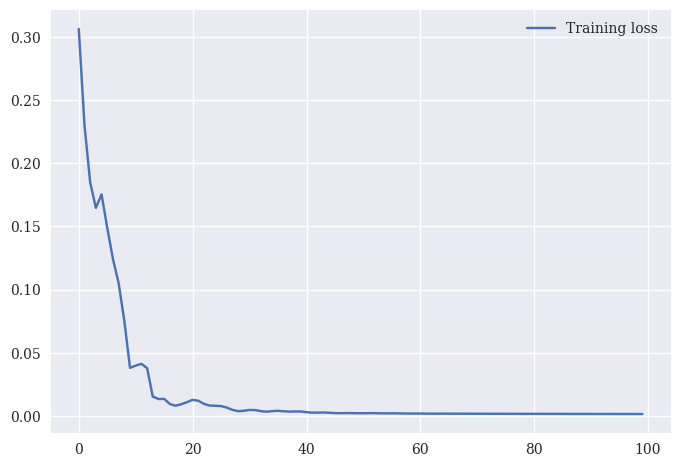

In [41]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [42]:
np.shape(y_train_pred)

torch.Size([998, 1])

In [ ]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df_fin[len(df_fin)-len(y_test):].index, y_test, color = 'red', label = 'Real IBM Stock Price')
axes.plot(df_fin[len(df_fin)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted IBM Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend()
plt.savefig('ibm_pred.png')
plt.show()